In [ ]:
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gdown
import zipfile

def gdrive_download(file_id: str,out_dir: str):
  """
    download [file_id] expected to be a zip
    and extract it to folder [out_dir]
  """
  url = "https://drive.google.com/uc?id=" + file_id
  output = 'dataset.zip'
  gdown.download(url, output, quiet=False,fuzzy=True)

  with zipfile.ZipFile(output, 'r') as zip_ref:
      zip_ref.extractall(out_dir)


dataset_dir = "dataset"
gdrive_download(file_id="1SCD-ExdkO3R0AT3j7FWEwkAoUIoxBR2s", out_dir = dataset_dir)

Downloading...
From: https://drive.google.com/uc?id=1SCD-ExdkO3R0AT3j7FWEwkAoUIoxBR2s
To: /content/dataset.zip
100%|██████████| 2.98M/2.98M [00:00<00:00, 181MB/s]


In [ ]:
!ls /content/dataset
# paths = "/content/drive/MyDrive/Rice_Image"

paths = os.path.join(dataset_dir,"Rice_Image")
print(paths)

Rice_Image
dataset/Rice_Image


In [ ]:
def loadImage(path, one_per_class = None):
  rice_images = []
  for data_name in os.listdir(path):
    current_dir = os.path.join(path,data_name)
    print(current_dir)

    if os.path.isdir(current_dir):
      current_data_path = os.path.join(current_dir)
      for filename in os.listdir(current_data_path):
        # print(filename)
        path_to_img = os.path.join(current_data_path, filename)
        img = cv2.imread(path_to_img, cv2.IMREAD_GRAYSCALE)
        # print(img)
        if img is not None:
          rice_images.append((data_name,img))
        if one_per_class:
          break


  return rice_images

data = loadImage(paths, one_per_class = False)
data_for_show = loadImage(paths, one_per_class = True)

dataset/Rice_Image/Arborio
dataset/Rice_Image/Karacadag
dataset/Rice_Image/Jasmine
dataset/Rice_Image/Basmati
dataset/Rice_Image/Ipsala
dataset/Rice_Image/Arborio
dataset/Rice_Image/Karacadag
dataset/Rice_Image/Jasmine
dataset/Rice_Image/Basmati
dataset/Rice_Image/Ipsala


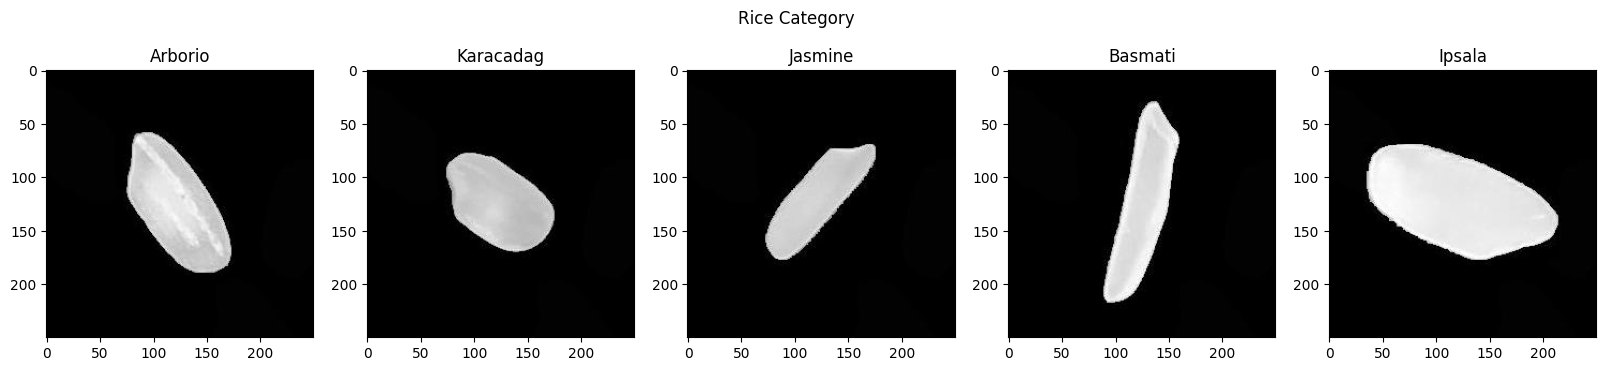

In [ ]:
import matplotlib.pyplot as plt

SHOW_COUNT = len(data_for_show)
fig, ax = plt.subplots(ncols = SHOW_COUNT, figsize=(20, 4))
fig.suptitle('Rice Category')

for i in range(SHOW_COUNT):
  label = data_for_show[i][0]
  img = data_for_show[i][1]

  ax[i].set_title(label)
  ax[i].imshow(img, cmap='gray')

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt

from torchvision.io import read_image

class CustomDataSet(Dataset):

  labels_map = {
      'Arborio' : 0,
      'Basmati' : 1,
      'Ipsala' : 2,
      'Jasmine' : 3,
      'Karacadag': 4
  }

  def __init__(self,transform=None, target_transform=None, data=None):
    self.transform= transform
    self.target_transform = target_transform
    self.data = data

  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    img = self.data[idx][1]
    label = self.data[idx][0]
    label_idx = self.labels_map[label]
    if self.transform:
      img = self.transform(img)
    if self.target_transform:
        label_idx = self.target_transform(label_idx)
    return img, label_idx


In [ ]:
custom_dataset = CustomDataSet(data= data, transform = ToTensor())
img = custom_dataset[0][0]

# Training And testing


In [ ]:
from torch.utils.data import random_split
TRAIN_TEST_SPLIT_RATIO = 0.8
print("original data length %d" % (len(custom_dataset)))
train_size = int(TRAIN_TEST_SPLIT_RATIO * len(custom_dataset))
test_size = len(custom_dataset) - train_size
training_data, test_data = random_split(custom_dataset,[train_size,test_size])

original data length 1000


In [ ]:
print("training data count: %d" % len(training_data))
print("test data count: %d" % len(test_data))

training data count: 800
test data count: 200


Model Creation


In [ ]:
from torch import nn
LABELS_LENGTH = len(custom_dataset.labels_map)
print(f"length of label {LABELS_LENGTH}")
IMAGE_SHAPE = (250, 250)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(IMAGE_SHAPE[0] * IMAGE_SHAPE[1], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, LABELS_LENGTH),
        )

    def forward(self, x):
        # print(f"Shape before flat {x.shape}")
        x = self.flatten(x)
        # print(f"Shape after flat {x.shape}")
        logits = self.linear_relu_stack(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(f"architecture of model:\n {model}")

length of label 5
architecture of model:
 NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=62500, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model,(IMAGE_SHAPE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 62500]               0
            Linear-2                  [-1, 512]      32,000,512
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                    [-1, 5]           2,565
Total params: 32,265,733
Trainable params: 32,265,733
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.24
Forward/backward pass size (MB): 0.49
Params size (MB): 123.08
Estimated Total Size (MB): 123.81
----------------------------------------------------------------


# Training Model


In [ ]:
from torch.utils.data import DataLoader
learning_rate = 1e-3
batch_size = 64
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  train_loss = 0
  train_correct = 0
  for batch_idx, (X,y) in enumerate(dataloader):
    pred = model(X)
    loss = loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  train_loss /= len(dataloader)
  train_accuracy = 100 * train_correct / size
  print(f"Training Loss: {train_loss:>7f}, Training Accuracy: {train_accuracy:>7f}%")
  return train_loss, train_accuracy

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    test_accuracy = 100 * test_correct / size
    print(f"Test Loss: {test_loss:>7f}, Test Accuracy: {test_accuracy:>7f}%")
    return test_loss, test_accuracy

In [ ]:
# Arrays to store the metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)

    # Store the metrics in arrays
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

print("Done!")

Epoch 1
-----------------------------------
Training Loss: 1.592613, Training Accuracy: 30.625000%
Test Loss: 1.586010, Test Accuracy: 34.500000%
Epoch 2
-----------------------------------
Training Loss: 1.564313, Training Accuracy: 35.750000%
Test Loss: 1.560715, Test Accuracy: 25.500000%
Epoch 3
-----------------------------------
Training Loss: 1.537372, Training Accuracy: 25.250000%
Test Loss: 1.534023, Test Accuracy: 30.000000%
Epoch 4
-----------------------------------
Training Loss: 1.513140, Training Accuracy: 37.750000%
Test Loss: 1.521484, Test Accuracy: 35.000000%
Epoch 5
-----------------------------------
Training Loss: 1.487433, Training Accuracy: 41.375000%
Test Loss: 1.492468, Test Accuracy: 40.500000%
Epoch 6
-----------------------------------
Training Loss: 1.458969, Training Accuracy: 45.125000%
Test Loss: 1.493231, Test Accuracy: 42.000000%
Epoch 7
-----------------------------------
Training Loss: 1.436046, Training Accuracy: 44.500000%
Test Loss: 1.409112, Test

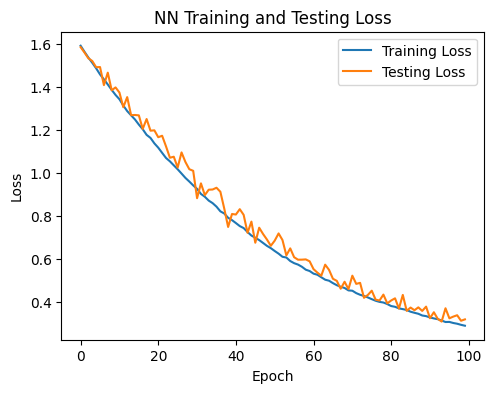

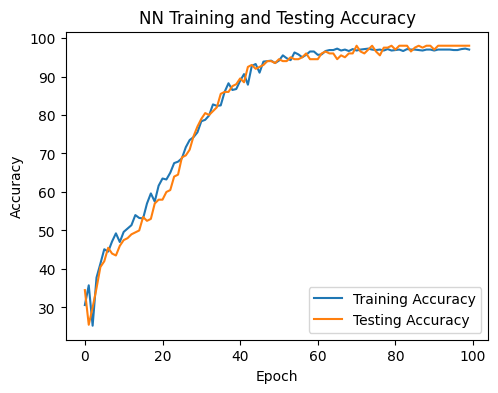

In [ ]:
import matplotlib.pyplot as plt

# Plot the summary graph of training and testing loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Training and Testing Loss')
plt.legend()
plt.show()

# Plot the summary graph of training and testing accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('NN Training and Testing Accuracy')
plt.legend()
plt.show()

# TRANSFER LEARNING

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the dataset
data_dir = paths
classes = os.listdir(data_dir)
num_classes = len(classes)
images = []
labels = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)
        labels.append(class_idx)
x = np.array(images)
y = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size =0.2)

# Set up data generators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow(
    x_train, y_train, batch_size=32)

if x_val.shape[0] > 0:
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow(
        x_val, y_val, batch_size=32)
else:
    val_generator = None

# Load the pre-trained model (e.g. MobileNetV2) and modify it by replacing the classification head
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, input_shape=(224, 224, 3), weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Add dropout layer to prevent overfitting
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

if val_generator:
    history = model.fit(
        train_generator,
        steps_per_epoch=len(x_train)//32,
        epochs=10,
        validation_data=val_generator,
        validation_steps=len(x_val)//32)
else:
    history = model.fit(
        train_generator,
        steps_per_epoch=len(x_train)//32,
        epochs=10)

# Store the training loss, training accuracy, testing loss, and testing accuracy in an array
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']


Epoch 1/10
25/25 [==============================] - 68s 2s/step - loss: 1.0744 - accuracy: 0.5925 - val_loss: 0.2627 - val_accuracy: 0.9427
Epoch 2/10
25/25 [==============================] - 66s 3s/step - loss: 0.3978 - accuracy: 0.8525 - val_loss: 0.1131 - val_accuracy: 0.9792
Epoch 3/10
25/25 [==============================] - 60s 2s/step - loss: 0.2423 - accuracy: 0.9150 - val_loss: 0.1271 - val_accuracy: 0.9688
Epoch 4/10
25/25 [==============================] - 61s 2s/step - loss: 0.1906 - accuracy: 0.9463 - val_loss: 0.1082 - val_accuracy: 0.9635
Epoch 5/10
25/25 [==============================] - 62s 2s/step - loss: 0.1685 - accuracy: 0.9388 - val_loss: 0.0968 - val_accuracy: 0.9688
Epoch 6/10
25/25 [==============================] - 60s 2s/step - loss: 0.1429 - accuracy: 0.9525 - val_loss: 0.0895 - val_accuracy: 0.9635
Epoch 7/10
25/25 [==============================] - 71s 3s/step - loss: 0.0960 - accuracy: 0.9675 - val_loss: 0.1152 - val_accuracy: 0.9583
Epoch 8/10
25/25 [==

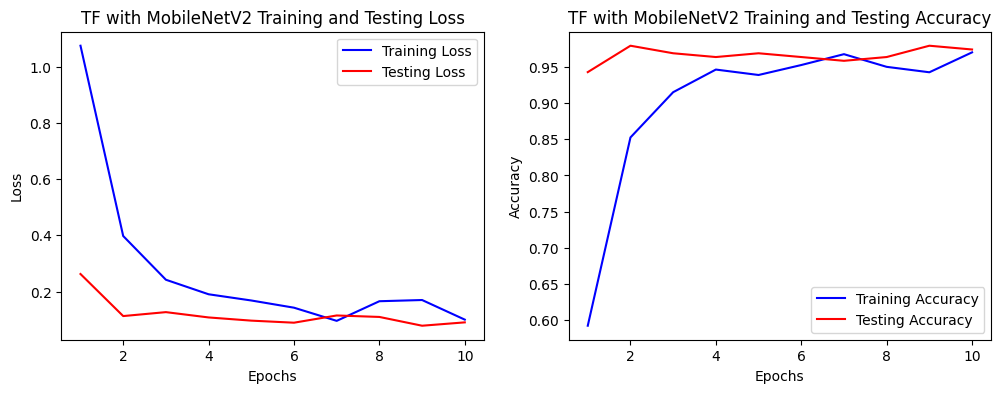

In [ ]:
# Plot summary graph of training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b-', label='Training Loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, 'r-', label='Testing Loss')
plt.title('TF with MobileNetV2 Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot a summary graph of testing loss and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'b-', label='Training Accuracy')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, 'r-', label='Testing Accuracy')
plt.title('TF with MobileNetV2 Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# # Training Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='NN')
# plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 'r-', label='MobileNetV2')
# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Training Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', label='NN')
# plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'r-', label='MobileNetV2')
# plt.title('Training Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Testing Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(test_losses) + 1), test_losses, 'b-', label='NN')
# plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], 'r-', label='MobileNetV2')
# plt.title('Testing Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Testing Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, 'b-', label='NN')
# plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'r-', label='MobileNetV2')
# plt.title('Testing Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()